### This is based on pytorch tutorial:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#### Install pycocotools, the version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354 and download dataset - kitti.

In [2]:
%%shell
gdown --id 1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV

Downloading...
From: https://drive.google.com/uc?id=1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV
To: /content/archive.zip
12.4GB [04:39, 44.2MB/s]


In [ ]:
!unzip archive.zip

In [4]:
!rm -rf archive.zip

In [ ]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Imports



In [163]:
from PennFundanDataset import PennFudanDataset
from ImageDirtier import ImageDirtier
from Prepare import get_instance_segmentation_model
import cv2
import numpy as np
import os
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import Augmentation as am
import Helpers as hp
from PIL import Image

#### Example

In [274]:
class KittiDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = list(sorted(os.listdir(os.path.join(root, "image_2"))))
    self.annotations = list(sorted(os.listdir(os.path.join(root, "label_2"))))

    for idx in range(len(self.imgs)):
      img_path = os.path.join(self.root, "image_2", self.imgs[idx])
      annotation_path = os.path.join(self.root, "label_2", self.annotations[idx])
      bndboxes, labels = self.read_annotations(annotation_path)
      if bndboxes == []:
        os.remove(img_path)
        os.remove(annotation_path)
    
    self.imgs = list(sorted(os.listdir(os.path.join(root, "image_2"))))
    self.annotations = list(sorted(os.listdir(os.path.join(root, "label_2"))))

    self.augmentations = []
    
  def read_annotations(self,filename):
    bndboxes = []
    labels = []
    with open(filename) as f:
      annotation = f.readline()

      while annotation:
        annotation = annotation.split(" ")
        label = annotation[0]
        if label != "Car":
          annotation = f.readline()
          continue
        x1, y1 = int(float(annotation[4])), int(float(annotation[5]))
        x2, y2 = int(float(annotation[6])), int(float(annotation[7]))
        bndboxes.append([x1,y1,x2,y2])
        labels.append(1)
        annotation = f.readline()

    return bndboxes,labels

  def __getitem__(self, idx):
    # load images ad masks
    img_path = os.path.join(self.root, "image_2", self.imgs[idx])
    annotation_path = os.path.join(self.root, "label_2", self.annotations[idx])
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)
    
    bndboxes,labels = self.read_annotations(annotation_path)

    boxes = torch.as_tensor(bndboxes, dtype=torch.float32)

    target = {}
    target["boxes"] = boxes
    target["labels"] = torch.as_tensor(labels,dtype=torch.int64)

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [259]:
img = Image.open('archive/kitti_single/training/image_2/000000.png')
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

FileNotFoundError: ignored

In [260]:
bndboxes, labels = read_annotations("archive/kitti_single/training/label_2/000001.txt")
print(bndboxes)
print(labels)

[[599, 156, 629, 189], [387, 181, 423, 203], [676, 163, 688, 193], [503, 169, 590, 190], [511, 174, 527, 187], [532, 176, 542, 185], [559, 175, 575, 183]]
['Truck', 'Car', 'Cyclist', 'DontCare', 'DontCare', 'DontCare', 'DontCare']


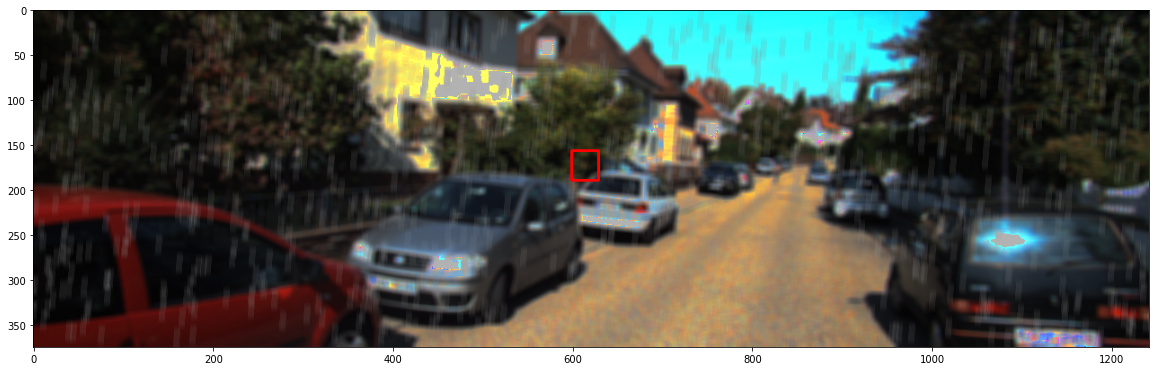

In [261]:
open_cv_image = np.array(img)
cv2.rectangle(open_cv_image, (bndboxes[0][0], bndboxes[0][1]), (bndboxes[0][2], bndboxes[0][3]), (255,0,0), 2)
plt.figure(figsize=(20,10))
plt.imshow(open_cv_image)
plt.show()

In [262]:
img_dirtier = ImageDirtier(15,5,10)
image = Image.open('archive/kitti_single/training/image_2/000008.png')
img = np.array(image)

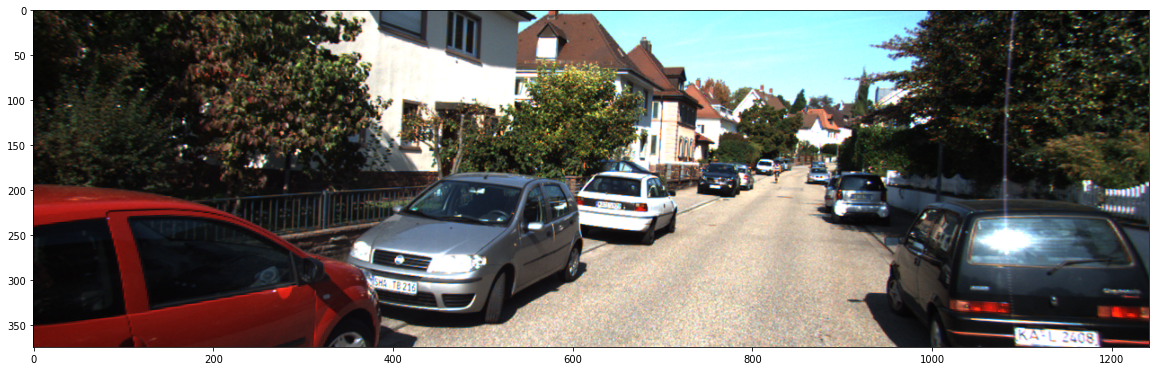

In [263]:
plt.figure(figsize = (20,10))
plt.imshow(img)

(375, 1242, 3)


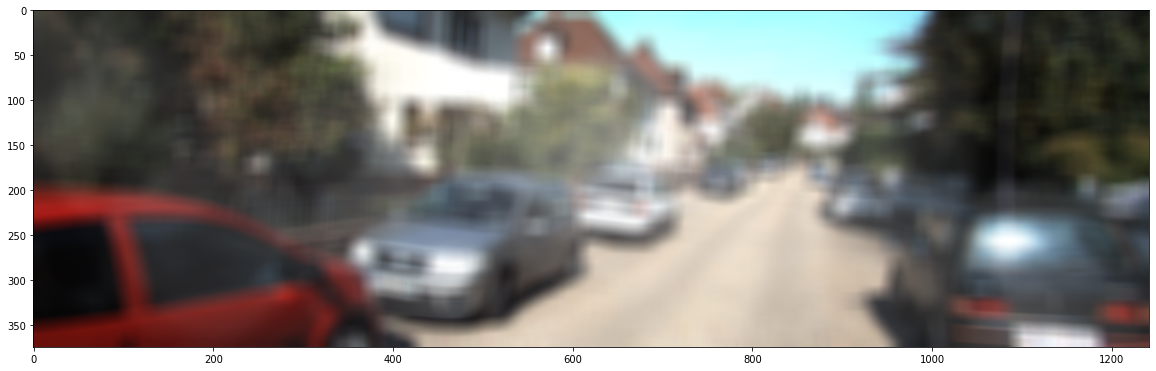

In [264]:
print(img.shape)
imgfog = am.add_fog(img)
plt.figure(figsize = (20,10))
plt.imshow(imgfog)

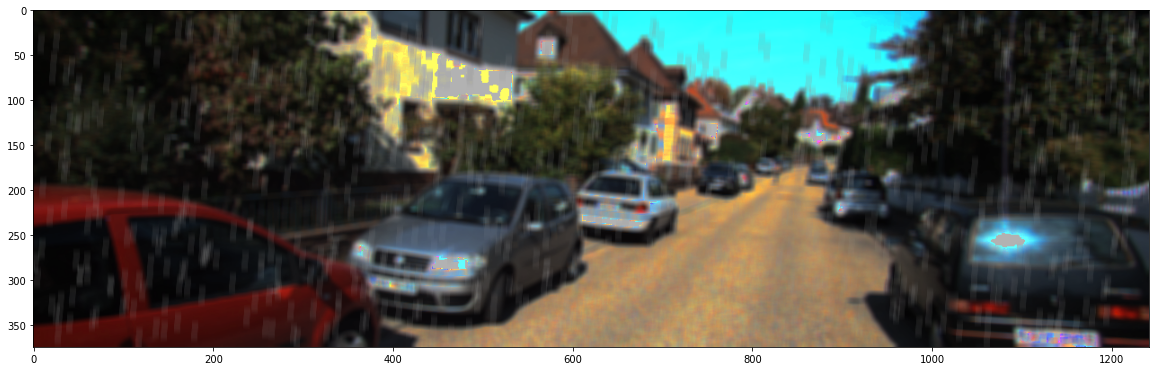

In [265]:
img = am.add_rain(img)
plt.figure(figsize = (20,10))
plt.imshow(img)

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [266]:
dataset = KittiDataset('archive/kitti_single/training/')
dataset[1]

tensor([[657., 190., 700., 223.]])


(array([[[  9,   7,   8],
         [  9,   8,   7],
         [  9,   7,   7],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[  9,   7,   7],
         [  9,   7,   6],
         [  8,   7,   6],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[  7,   8,   7],
         [  7,   7,   6],
         [  8,   6,   6],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 14,  15,  17],
         [ 13,  14,  16],
         [ 13,  14,  15],
         ...,
         [ 44,  30,  23],
         [ 50,  31,  22],
         [ 53,  37,  26]],
 
        [[ 12,  15,  15],
         [ 13,  15,  16],
         [ 13,  15,  16],
         ...,
         [ 43,  32,  21],
         [ 49,  33,  19],
         [ 54,  38,  24]],
 
        [[ 17,  16,  14],
         [ 17,  16,  16],
         [ 17,  16,  16],
         ...,
         [ 48,  33,  22],
  

## Defining your model
Faster R-CNN

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)



In [267]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` there is a number of helper functions to simplify training and evaluating detection models.
Here, I will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [195]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [275]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # I will maybe add more of them
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [276]:
# use our dataset and defined transformations
dataset = KittiDataset('archive/kitti_single/training/', get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [277]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [278]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# here I will probably add option to use some evolutionary algorithm to optimize this params, training speed will drop
# a lot if we use it but results should be better
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [279]:
dataset[1]

(tensor([[[0.3647, 0.3725, 0.3765,  ..., 0.4392, 0.4392, 0.4431],
          [0.3647, 0.3647, 0.3608,  ..., 0.4431, 0.4431, 0.4431],
          [0.3647, 0.3647, 0.3647,  ..., 0.4549, 0.4588, 0.4588],
          ...,
          [0.4510, 0.4510, 0.4471,  ..., 0.3412, 0.3490, 0.3490],
          [0.4588, 0.4510, 0.4471,  ..., 0.3373, 0.3490, 0.3490],
          [0.4941, 0.4627, 0.4431,  ..., 0.3529, 0.3529, 0.3529]],
 
         [[0.5922, 0.5922, 0.5922,  ..., 0.6941, 0.6863, 0.6863],
          [0.5843, 0.5882, 0.5961,  ..., 0.6980, 0.6980, 0.6941],
          [0.5804, 0.5843, 0.5922,  ..., 0.6941, 0.6941, 0.6863],
          ...,
          [0.4627, 0.4549, 0.4235,  ..., 0.3608, 0.3686, 0.3765],
          [0.4667, 0.4471, 0.4157,  ..., 0.3647, 0.3765, 0.3843],
          [0.4784, 0.4471, 0.4235,  ..., 0.3725, 0.3804, 0.3804]],
 
         [[0.8784, 0.8745, 0.8824,  ..., 0.9804, 0.9843, 0.9804],
          [0.8784, 0.8784, 0.8784,  ..., 0.9961, 0.9961, 0.9765],
          [0.8824, 0.8824, 0.8745,  ...,

In [ ]:
# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/3317]  eta: 0:40:44  lr: 0.000010  loss: 1.1865 (1.1865)  loss_classifier: 0.7080 (0.7080)  loss_box_reg: 0.4410 (0.4410)  loss_objectness: 0.0355 (0.0355)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.7370  data: 0.2464  max mem: 2839
Epoch: [0]  [  10/3317]  eta: 0:21:32  lr: 0.000060  loss: 1.1114 (1.1744)  loss_classifier: 0.6676 (0.6706)  loss_box_reg: 0.4150 (0.4489)  loss_objectness: 0.0381 (0.0443)  loss_rpn_box_reg: 0.0071 (0.0106)  time: 0.3907  data: 0.0281  max mem: 3108
Epoch: [0]  [  20/3317]  eta: 0:20:36  lr: 0.000110  loss: 1.0482 (1.1347)  loss_classifier: 0.5683 (0.5777)  loss_box_reg: 0.4177 (0.4973)  loss_objectness: 0.0404 (0.0475)  loss_rpn_box_reg: 0.0095 (0.0121)  time: 0.3570  data: 0.0064  max mem: 3108


Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, target = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

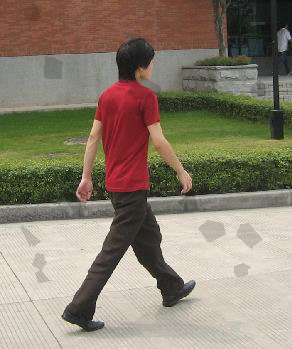

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

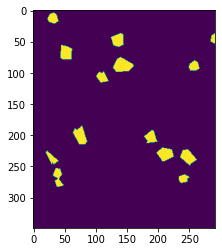

In [ ]:
all_masks = np.zeros(target['masks'][0].shape)
for mask in target['masks']:
  all_masks += mask.numpy()
plt.imshow(all_masks)
plt.show()

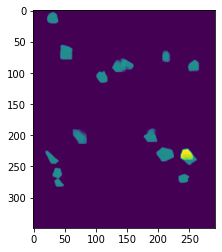

In [ ]:
all_masks = np.zeros(target['masks'][0].shape)
iterator = 0
for mask in prediction[0]['masks']:
  if prediction[0]['scores'][iterator] < 0.5:
    break
  iterator += 1
  shape = mask.to('cpu').numpy().shape
  all_masks += mask.to('cpu').numpy().reshape(shape[1],shape[2])
plt.imshow(all_masks)
plt.show()

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

0
tensor(0.9921, device='cuda:0')


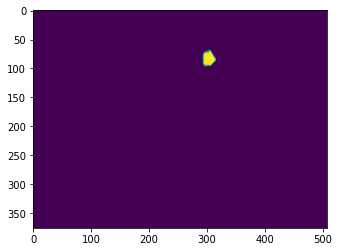

1
tensor(0.9910, device='cuda:0')


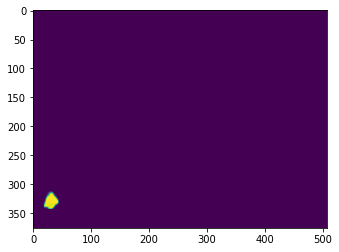

2
tensor(0.9729, device='cuda:0')


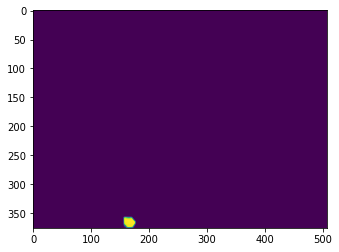

3
tensor(0.9683, device='cuda:0')


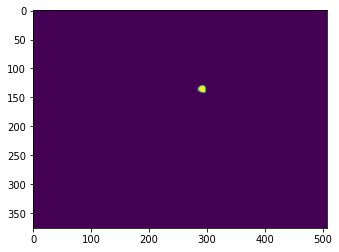

4
tensor(0.9358, device='cuda:0')


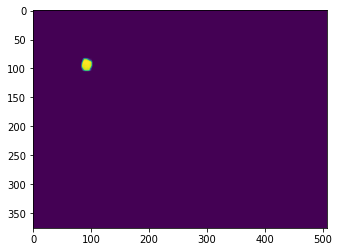

5
tensor(0.8945, device='cuda:0')


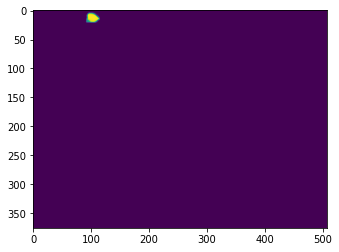

6
tensor(0.8882, device='cuda:0')


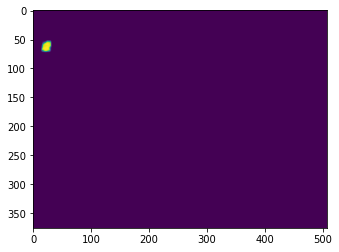

7
tensor(0.7811, device='cuda:0')


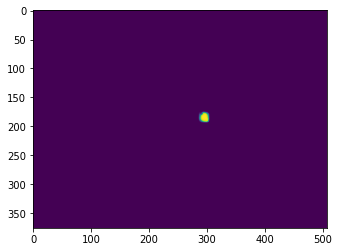

8
tensor(0.5845, device='cuda:0')


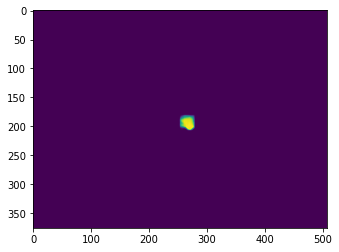

9
tensor(0.5530, device='cuda:0')


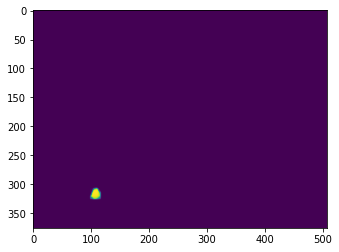

In [ ]:
for i in range(prediction[0]['masks'].shape[0]):
  if prediction[0]['scores'][i] < 0.5:
    break
  print(i)
  print(prediction[0]['scores'][i])
  mask = prediction[0]['masks'][i].permute(1,2,0).to('cpu')
  plt.imshow(mask.reshape(mask.shape[0],mask.shape[1]))
  plt.show()